In [1]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

## Init Data

In [2]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
weights, x, c = spo.data.knapsack.genData(n+1000, p, m, deg=deg, cor=False)

In [3]:
weights

array([6, 6, 6, 7, 3, 5, 7, 4, 6, 7, 3, 6, 3, 3, 7, 6, 3, 7, 7, 6, 3, 4,
       6, 3, 5, 6, 3, 3, 4, 3, 4, 3, 6, 7, 4, 4, 6, 4, 4, 5, 7, 6, 3, 3,
       7, 5, 4, 4])

In [4]:
# convert max into min
c = - c

## Optimization model 

In [5]:
# capacity
cap = 30

In [6]:
ks_model = spo.model.knapsackModel(weights, cap)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [7]:
# solve
ks_model.setObj([-i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
Obj: -329.0
26
27
29
31
38
42
43
46
47


In [8]:
# relax
ks_model_rel = ks_model.relax()

In [9]:
# solve
ks_model_rel.setObj([-i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.4, 1.0, 1.0]
Obj: -331.0
29
31
37
38
42
43
45
46
47


## Data Loader 

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [11]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [12]:
# get training data set
ks_dataset_train = spo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 247.98it/s]


In [13]:
# get training data set for relaxation
ks_dataset_train_rel = spo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.15it/s]


In [14]:
# get test data set
ks_dataset_test = spo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 256.84it/s]


In [15]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [16]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [17]:
x.shape

torch.Size([32, 5])

In [18]:
c.shape

torch.Size([32, 48])

In [19]:
w.shape

torch.Size([32, 48])

In [20]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [23]:
# build model
twostage_model = spo.twostage.sklearnPred(reg, ks_model)

In [24]:
# training
twostage_model.fit(ks_dataset_train.x, ks_dataset_train.c)

In [25]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.x)

In [26]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.c[i]
    z_true_i = ks_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.z.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.36it/s]


Normalized true SPO Loss: 2.09%
Normalized unambiguous SPO Loss: 2.09%


In [27]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: 2.73, 7.06, 13.91, 2.73, 6.00, 10.63, 7.79, 10.89, 6.59, 7.06, 10.01, 3.78, 10.63, 13.83, 2.73, 13.16, 7.88, 7.27, 13.16, 7.88, 6.59, 13.91, 13.16, 3.96, 5.43, 7.06, 3.96, 2.73, 7.06, 17.33, 7.10, 9.77, 10.82, 11.26, 14.18, 14.32, 1.56, 5.43, 1.56, 17.33, 5.43, 6.00, 10.01, 0.43, 2.73, 5.43, 17.33, 8.19
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Sample

## Linear Regression from PyTorch

In [28]:
from torch import nn

In [29]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [30]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [31]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [32]:
# init SPO+ loss
criterion = spo.func.SPOPlus()

In [33]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(ks_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  41.1494, True SPO Loss:  8.4499%, Unambiguous SPO Loss:  8.4499%
Epoch  20, Loss:  23.2651, True SPO Loss:  2.2808%, Unambiguous SPO Loss:  2.2808%
Epoch  30, Loss:  32.3797, True SPO Loss:  1.4049%, Unambiguous SPO Loss:  1.4049%
Epoch  40, Loss:   4.1790, True SPO Loss:  0.8168%, Unambiguous SPO Loss:  0.8168%
Epoch  50, Loss:   1.7077, True SPO Loss:  0.6366%, Unambiguous SPO Loss:  0.6366%
Epoch  60, Loss:   5.0745, True SPO Loss:  0.5823%, Unambiguous SPO Loss:  0.5823%
Epoch  70, Loss:   1.4560, True SPO Loss:  0.4699%, Unambiguous SPO Loss:  0.4699%
Epoch  80, Loss:   1.8350, True SPO Loss:  0.4166%, Unambiguous SPO Loss:  0.4166%
Epoch  90, Loss:   3.0775, True SPO Loss:  0.4060%, Unambiguous SPO Loss:  0.4060%
Epoch 100, Loss:   3.8860, True SPO Loss:  0.3856%, Unambiguous SPO Loss:  0.3856%
Epoch 110, Loss:   0.4503, True SPO Loss:  0.3769%, Unambiguous SPO Loss:  0.3769%
Epoch 120, Loss:   9.7379, True SPO Loss:  0.3459%, Unambiguous SPO Loss:  0.3459%
Epoc

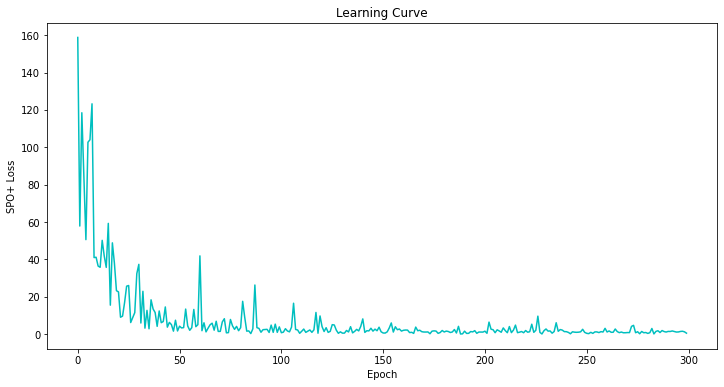

In [34]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

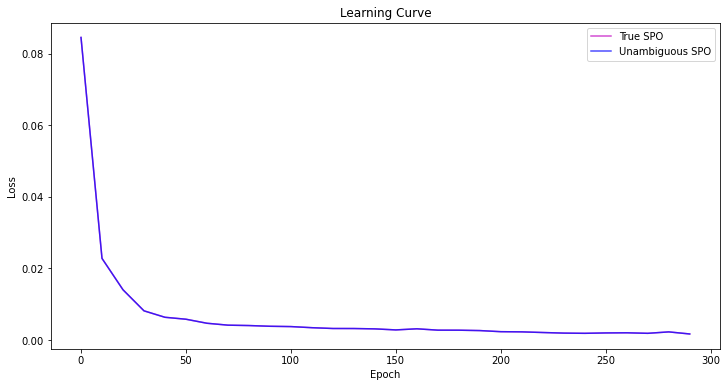

In [35]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [36]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.17%
Normalized unambiguous SPO Loss: 0.17%


In [37]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: -6.32, -0.13, 11.36, 2.29, 5.92, 9.19, 4.46, 11.13, 0.16, -1.43, 8.47, -1.93, 9.08, 14.27, -7.13, 7.96, 7.38, 3.54, -1.21, 6.13, 3.39, 13.32, 6.86, 1.41, -2.23, 1.27, 1.33, -2.45, 4.35, 18.67, 2.40, 7.34, 10.49, 11.99, 15.77, 15.89, -7.76, -1.24, -4.86, 17.38, -2.92, 2.14, 8.27, -4.89, -4.21, -3.13, 18.34, 7.84
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

## SPO+ with Regularization

In [38]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [39]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [40]:
# init SPO+ loss
criterion = spo.func.SPOPlus()

In [41]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(ks_model, cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  77.2793, True SPO Loss:  7.7775%, Unambiguous SPO Loss:  7.7775%
Epoch  20, Loss:   8.4025, True SPO Loss:  1.8487%, Unambiguous SPO Loss:  1.8487%
Epoch  30, Loss:  20.4018, True SPO Loss:  1.1288%, Unambiguous SPO Loss:  1.1288%
Epoch  40, Loss:  43.5987, True SPO Loss:  0.7451%, Unambiguous SPO Loss:  0.7451%
Epoch  50, Loss:   9.2854, True SPO Loss:  0.5726%, Unambiguous SPO Loss:  0.5726%
Epoch  60, Loss:   2.2919, True SPO Loss:  0.4883%, Unambiguous SPO Loss:  0.4883%
Epoch  70, Loss:   3.2798, True SPO Loss:  0.4757%, Unambiguous SPO Loss:  0.4757%
Epoch  80, Loss:   4.3269, True SPO Loss:  0.4312%, Unambiguous SPO Loss:  0.4312%
Epoch  90, Loss:   2.2688, True SPO Loss:  0.3788%, Unambiguous SPO Loss:  0.3788%
Epoch 100, Loss:   2.5278, True SPO Loss:  0.3401%, Unambiguous SPO Loss:  0.3401%
Epoch 110, Loss:   1.2568, True SPO Loss:  0.3478%, Unambiguous SPO Loss:  0.3478%
Epoch 120, Loss:  13.7318, True SPO Loss:  0.3314%, Unambiguous SPO Loss:  0.3314%
Epoc

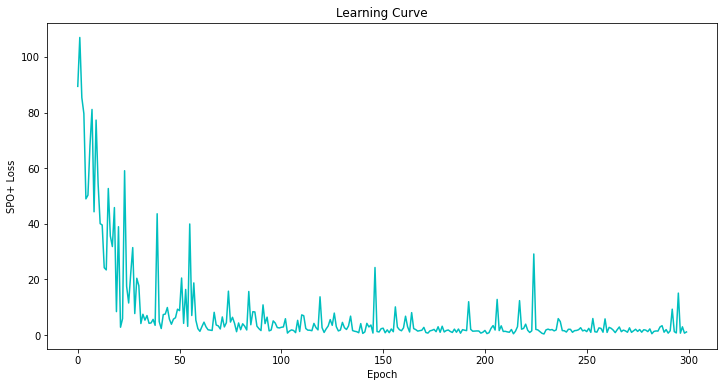

In [42]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

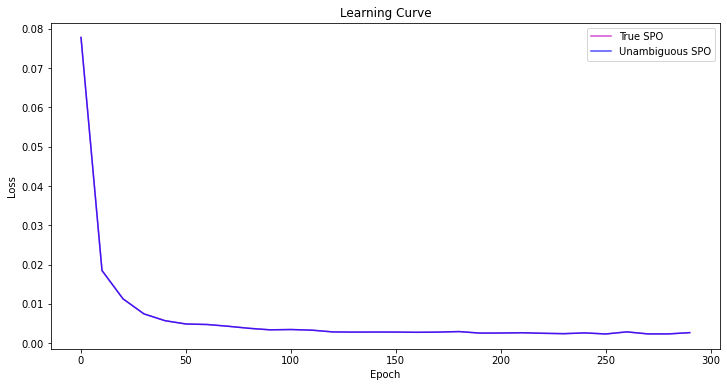

In [43]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [44]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.27%
Normalized unambiguous SPO Loss: 0.27%


In [45]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: -1.08, 5.65, 13.63, 2.88, 6.17, 9.60, 6.79, 10.93, 3.17, 6.60, 7.88, -0.38, 9.57, 13.59, 2.26, 9.70, 7.60, 6.10, 10.17, 7.56, 4.31, 14.02, 9.38, 1.86, -1.11, 4.72, 2.32, -0.91, 4.86, 18.45, 2.92, 7.32, 9.91, 13.44, 15.50, 16.25, -4.51, -0.79, -1.70, 17.80, 3.71, 5.49, 8.16, -1.91, 1.49, -0.16, 17.25, 8.06
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Samp

Sample 9:
    True cost: 22.00, 12.00, 8.00, 22.00, 6.00, 10.00, 3.00, 6.00, 18.00, 12.00, 28.00, 7.00, 10.00, 17.00, 22.00, 19.00, 7.00, 23.00, 19.00, 7.00, 18.00, 8.00, 19.00, 15.00, 27.00, 12.00, 15.00, 22.00, 12.00, 20.00, 6.00, 16.00, 19.00, 4.00, 5.00, 11.00, 5.00, 27.00, 5.00, 20.00, 27.00, 6.00, 28.00, 9.00, 22.00, 27.00, 20.00, 15.00
    Pred cost: 17.29, 10.33, 3.97, 16.39, 5.22, 7.18, -3.30, 3.50, 15.62, 9.73, 19.75, 4.24, 7.61, 12.81, 16.06, 15.93, 5.74, 17.94, 15.31, 5.07, 13.53, 5.23, 16.50, 11.48, 20.42, 10.12, 11.75, 16.87, 9.63, 16.24, 1.66, 12.36, 15.58, 0.05, 0.57, 8.68, 0.25, 19.90, 0.99, 16.28, 20.15, 4.05, 19.73, 7.06, 15.13, 19.85, 16.52, 12.13
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, True obj: 203.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

## SPO+ Rel 

In [46]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [47]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [48]:
# init SPO+ loss
criterion = spo.func.SPOPlus()

In [49]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(ks_model_rel, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  85.9549, True SPO Loss:  6.5102%, Unambiguous SPO Loss:  6.5102%
Epoch  20, Loss:  12.8144, True SPO Loss:  2.1558%, Unambiguous SPO Loss:  2.1558%
Epoch  30, Loss:  20.1874, True SPO Loss:  1.0745%, Unambiguous SPO Loss:  1.0745%
Epoch  40, Loss:  18.9148, True SPO Loss:  0.6666%, Unambiguous SPO Loss:  0.6666%
Epoch  50, Loss:   1.5867, True SPO Loss:  0.5242%, Unambiguous SPO Loss:  0.5242%
Epoch  60, Loss:  19.1845, True SPO Loss:  0.4612%, Unambiguous SPO Loss:  0.4612%
Epoch  70, Loss:   1.5143, True SPO Loss:  0.4777%, Unambiguous SPO Loss:  0.4777%
Epoch  80, Loss:   0.8740, True SPO Loss:  0.4069%, Unambiguous SPO Loss:  0.4069%
Epoch  90, Loss:   3.5694, True SPO Loss:  0.3633%, Unambiguous SPO Loss:  0.3633%
Epoch 100, Loss:  12.5688, True SPO Loss:  0.3585%, Unambiguous SPO Loss:  0.3585%
Epoch 110, Loss:   0.9426, True SPO Loss:  0.3449%, Unambiguous SPO Loss:  0.3449%
Epoch 120, Loss:   3.8207, True SPO Loss:  0.3391%, Unambiguous SPO Loss:  0.3391%
Epoc

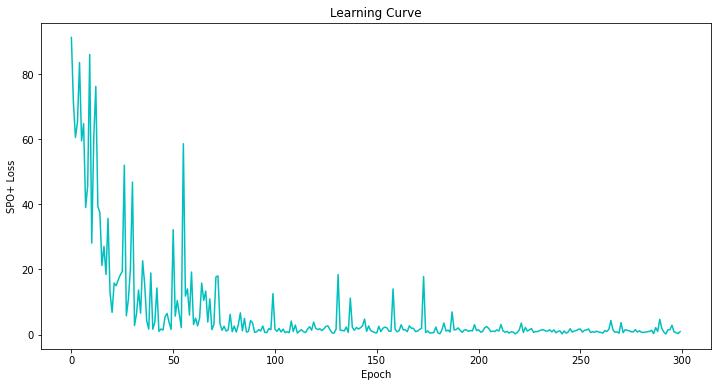

In [50]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

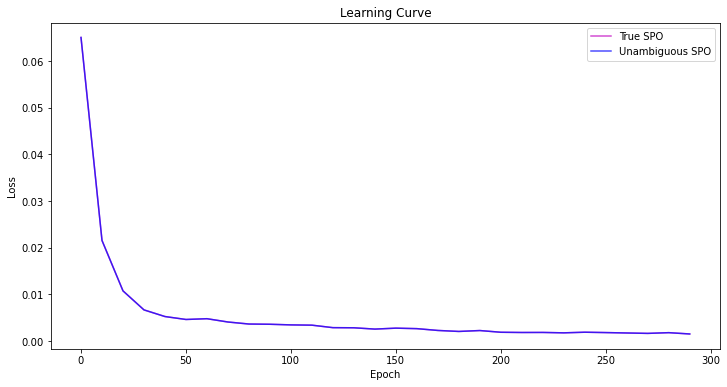

In [51]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [52]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.15%
Normalized unambiguous SPO Loss: 0.15%


In [53]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: -5.36, 1.01, 13.76, -1.63, 6.69, 9.32, 4.40, 11.74, -1.48, 2.12, 9.29, -5.69, 9.84, 14.75, -2.71, 8.12, 8.25, 1.99, 5.55, 7.49, 3.70, 14.13, 8.33, 1.19, -2.13, 1.64, 1.27, -1.55, 3.88, 19.67, 2.07, 6.35, 9.83, 14.39, 17.23, 17.55, -6.63, -1.48, -3.46, 19.22, -0.34, 4.38, 9.32, -3.41, -0.59, -2.28, 19.09, 8.09
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00



## SPO+ Rel with Regularization 

In [54]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [55]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [56]:
# init SPO+ loss
criterion = spo.func.SPOPlus()

In [57]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(ks_model_rel, cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  73.2851, True SPO Loss:  7.7310%, Unambiguous SPO Loss:  7.7310%
Epoch  20, Loss:  25.2648, True SPO Loss:  2.0667%, Unambiguous SPO Loss:  2.0667%
Epoch  30, Loss:  30.6999, True SPO Loss:  1.0610%, Unambiguous SPO Loss:  1.0610%
Epoch  40, Loss:   3.4248, True SPO Loss:  0.6889%, Unambiguous SPO Loss:  0.6889%
Epoch  50, Loss:   6.4455, True SPO Loss:  0.5668%, Unambiguous SPO Loss:  0.5668%
Epoch  60, Loss:   1.2595, True SPO Loss:  0.4486%, Unambiguous SPO Loss:  0.4486%
Epoch  70, Loss:  26.2535, True SPO Loss:  0.3856%, Unambiguous SPO Loss:  0.3856%
Epoch  80, Loss:   1.0375, True SPO Loss:  0.3827%, Unambiguous SPO Loss:  0.3827%
Epoch  90, Loss:   1.9330, True SPO Loss:  0.3595%, Unambiguous SPO Loss:  0.3595%
Epoch 100, Loss:   0.9444, True SPO Loss:  0.3507%, Unambiguous SPO Loss:  0.3507%
Epoch 110, Loss:   4.3748, True SPO Loss:  0.2965%, Unambiguous SPO Loss:  0.2965%
Epoch 120, Loss:   2.0716, True SPO Loss:  0.2916%, Unambiguous SPO Loss:  0.2916%
Epoc

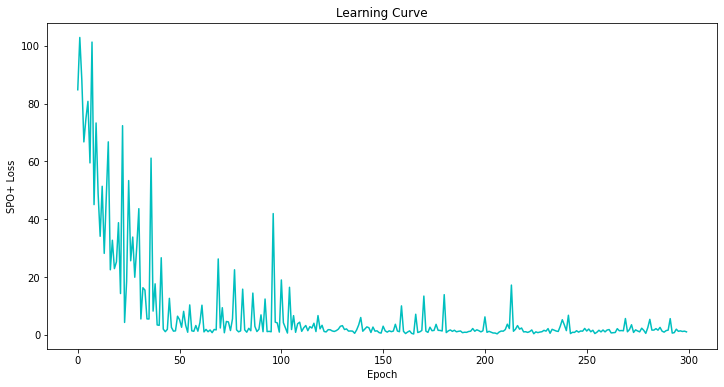

In [58]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

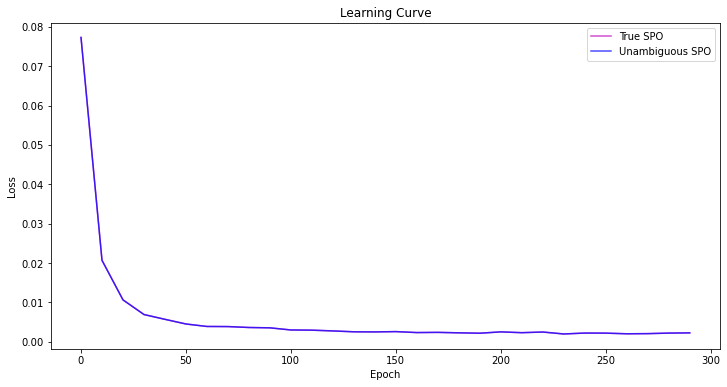

In [59]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [60]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.22%
Normalized unambiguous SPO Loss: 0.22%


In [61]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: -1.28, 5.56, 15.21, 2.79, 6.98, 9.21, 5.86, 11.28, 4.20, 6.53, 9.02, 0.75, 10.14, 13.95, 2.10, 10.41, 8.25, 6.77, 13.42, 9.19, 4.18, 14.13, 9.86, 1.88, -0.19, 4.88, 2.17, -1.11, 5.70, 18.92, 4.58, 7.00, 11.09, 13.73, 16.01, 15.77, -0.95, 1.26, -1.03, 18.35, 5.06, 6.23, 9.03, -1.21, 1.60, -0.21, 17.80, 8.68
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Sam

    True sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, -0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 51.00
    Pred sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 51.00

Sample 9:
    True cost: 22.00, 12.00, 8.00, 22.00, 6.00, 10.00, 3.00, 6.00, 18.00, 12.00, 28.00, 7.00, 10.00, 17.00, 22.00, 19.00, 7.00, 23.00, 19.00, 7.00, 18.00, 8.00, 19.00, 15.00, 27.00, 12.00, 15.00, 22.00, 12.00, 20.00, 6.00, 16.00, 19.00, 4.00, 5.00, 11.00, 5.00, 27.00, 5.00, 20.00, 27.00, 6.00, 28.00, 9.00, 22.00, 27.00, 20.00, 15.00
    Pred cost: 18.53, 10.77, 5.24, 16.03, 5.10, 7.80, -2.92, 4.12, 15.92, 11.28, 19.77, 5.16, 7.48, 13.62, 19.20, 16.23, 6.20, 20.27, 17.42, 5.99, 14.26, 4.93, 16.38, 11.74, 21.38, 10.68, 11.52, 17.41, 10.30, 15.75, 2.70, 12.46, 17.27, 1.09, 1.77, 9.63, 3.33, 20.35, 2.85, 17.00, 19.98, 3.41, 19.96, 7.84,

## Black-Box

In [62]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [63]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [64]:
# set loss
criterion = nn.L1Loss()

In [65]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = spo.func.blackboxOpt.apply(ks_model, cp, lambd)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  19.1250, True SPO Loss: 15.0589%, Unambiguous SPO Loss: 15.0589%
Epoch  20, Loss:   4.5000, True SPO Loss:  3.9658%, Unambiguous SPO Loss:  3.9658%
Epoch  30, Loss:   1.2500, True SPO Loss:  1.2858%, Unambiguous SPO Loss:  1.2858%
Epoch  40, Loss:   1.0000, True SPO Loss:  0.7092%, Unambiguous SPO Loss:  0.7092%
Epoch  50, Loss:   0.2500, True SPO Loss:  0.5252%, Unambiguous SPO Loss:  0.5252%
Epoch  60, Loss:   0.2500, True SPO Loss:  0.4738%, Unambiguous SPO Loss:  0.4738%
Epoch  70, Loss:   0.1250, True SPO Loss:  0.3856%, Unambiguous SPO Loss:  0.3856%
Epoch  80, Loss:   0.1250, True SPO Loss:  0.3062%, Unambiguous SPO Loss:  0.3062%
Epoch  90, Loss:   0.1250, True SPO Loss:  0.2955%, Unambiguous SPO Loss:  0.2955%
Epoch 100, Loss:   0.2500, True SPO Loss:  0.2529%, Unambiguous SPO Loss:  0.2529%
Epoch 110, Loss:   0.0000, True SPO Loss:  0.2054%, Unambiguous SPO Loss:  0.2054%
Epoch 120, Loss:   0.1250, True SPO Loss:  0.2103%, Unambiguous SPO Loss:  0.2103%
Epoc

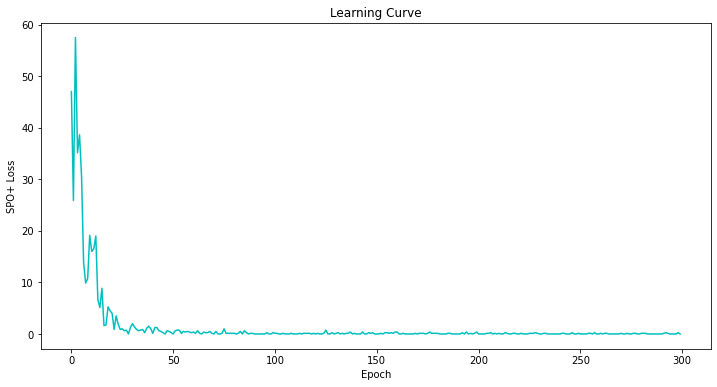

In [66]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

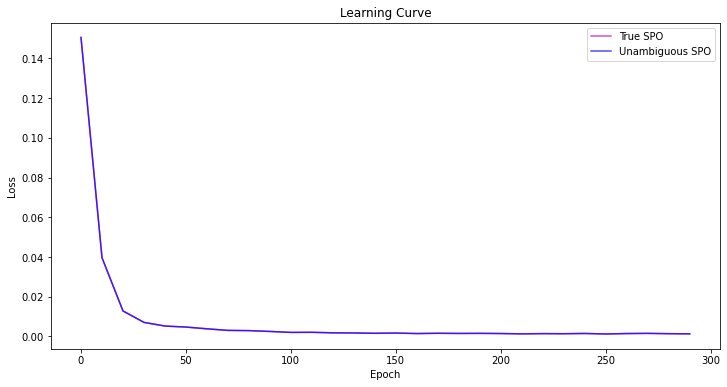

In [67]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [68]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.13%
Normalized unambiguous SPO Loss: 0.13%


In [69]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: -0.66, -0.13, 0.51, 0.20, 0.23, 0.30, -0.05, 0.43, -0.20, -0.12, 0.34, -0.78, 0.38, 0.51, -0.56, 0.31, 0.33, -0.08, -0.74, 0.14, 0.12, 0.54, 0.25, 0.06, -0.18, -0.10, 0.06, -0.09, 0.13, 0.64, 0.03, 0.30, 0.26, 0.35, 0.69, 0.71, -0.93, -0.06, -0.37, 0.72, -0.12, -0.04, 0.32, -0.18, -0.05, -0.19, 0.69, 0.31
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Samp

    True sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, -0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 51.00
    Pred sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 51.00

Sample 9:
    True cost: 22.00, 12.00, 8.00, 22.00, 6.00, 10.00, 3.00, 6.00, 18.00, 12.00, 28.00, 7.00, 10.00, 17.00, 22.00, 19.00, 7.00, 23.00, 19.00, 7.00, 18.00, 8.00, 19.00, 15.00, 27.00, 12.00, 15.00, 22.00, 12.00, 20.00, 6.00, 16.00, 19.00, 4.00, 5.00, 11.00, 5.00, 27.00, 5.00, 20.00, 27.00, 6.00, 28.00, 9.00, 22.00, 27.00, 20.00, 15.00
    Pred cost: 0.37, -0.09, -0.33, -0.17, 0.01, -0.00, -0.94, -0.11, 0.32, -0.18, 0.64, -0.90, 0.20, 0.42, 0.15, 0.37, 0.07, 0.52, -0.18, -0.40, 0.46, 0.01, 0.39, 0.36, 0.67, -0.11, 0.37, 0.59, 0.18, 0.51, -0.19, 0.40, 0.20, -1.19, -0.24, 0.19, -1.05, 0.65, -0.40, 0.51, 0.77, -0.60, 0.69, 0.16, -0.07, 0.

## Black-Box with Regularization 

In [70]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [71]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [72]:
# set loss
criterion = nn.L1Loss()

In [73]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = spo.func.blackboxOpt.apply(ks_model, cp, lambd)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  11.6965, True SPO Loss: 13.0513%, Unambiguous SPO Loss: 13.0513%
Epoch  20, Loss:   3.0064, True SPO Loss:  2.8980%, Unambiguous SPO Loss:  2.8990%
Epoch  30, Loss:   0.3982, True SPO Loss:  1.1782%, Unambiguous SPO Loss:  1.1782%
Epoch  40, Loss:   0.8542, True SPO Loss:  0.7422%, Unambiguous SPO Loss:  0.7422%
Epoch  50, Loss:   0.4538, True SPO Loss:  0.5300%, Unambiguous SPO Loss:  0.5300%
Epoch  60, Loss:   0.4708, True SPO Loss:  0.4428%, Unambiguous SPO Loss:  0.4428%
Epoch  70, Loss:   0.4656, True SPO Loss:  0.3653%, Unambiguous SPO Loss:  0.3653%
Epoch  80, Loss:   0.6326, True SPO Loss:  0.3042%, Unambiguous SPO Loss:  0.3042%
Epoch  90, Loss:   0.3029, True SPO Loss:  0.2335%, Unambiguous SPO Loss:  0.2335%
Epoch 100, Loss:   0.5287, True SPO Loss:  0.2199%, Unambiguous SPO Loss:  0.2199%
Epoch 110, Loss:   0.2716, True SPO Loss:  0.2287%, Unambiguous SPO Loss:  0.2287%
Epoch 120, Loss:   0.4184, True SPO Loss:  0.1792%, Unambiguous SPO Loss:  0.1792%
Epoc

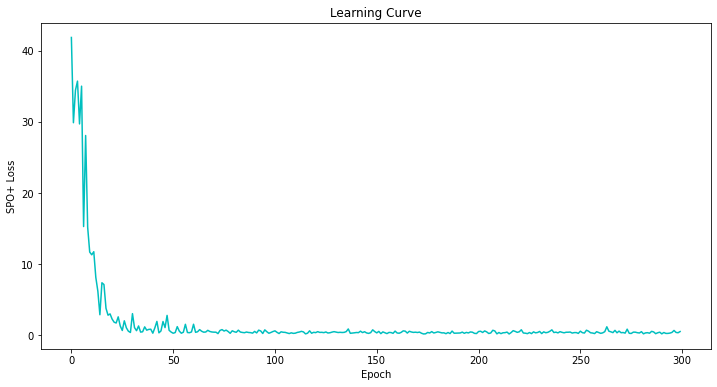

In [74]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

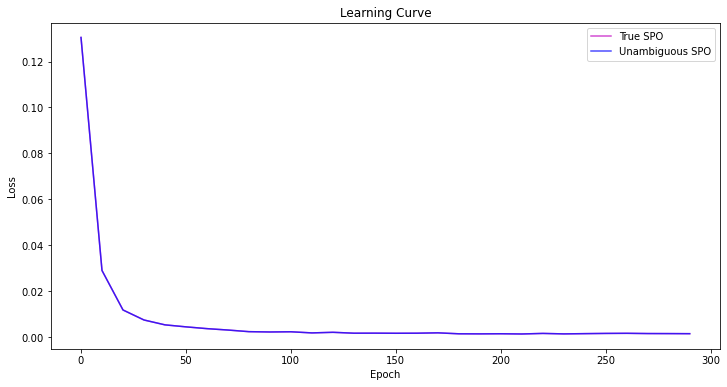

In [75]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [76]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.15%
Normalized unambiguous SPO Loss: 0.15%


In [77]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: -0.30, -0.24, 0.80, 0.90, 0.36, 0.56, 0.44, 0.64, 0.11, 0.83, 0.50, -0.15, 0.55, 0.74, 0.34, 0.45, 0.47, 0.36, 0.58, 0.43, 0.29, 0.78, 0.56, 0.21, -0.11, 0.05, 0.14, -0.00, 0.25, 0.87, 0.23, 0.44, 0.65, 0.81, 0.95, 1.01, -0.38, 0.08, -0.28, 1.05, 0.44, 0.37, 0.49, -0.11, -0.22, -0.13, 0.96, 0.48
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Sample 1:
    